In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score, cross_validate
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline
plt.style.use('seaborn-white')

# Data

In [3]:
df_auto = pd.read_csv('Data/Auto.csv', na_values='?').dropna()
df_auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 396
Data columns (total 9 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null int64
acceleration    392 non-null float64
year            392 non-null int64
origin          392 non-null int64
name            392 non-null object
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


In [4]:
df_auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


# 5.1 Cross-Validation

## 5.1.1 The Validation Set Approach

### FIGURE 5.2

Mean ± std of MSE for p=2: 19.33±2.10


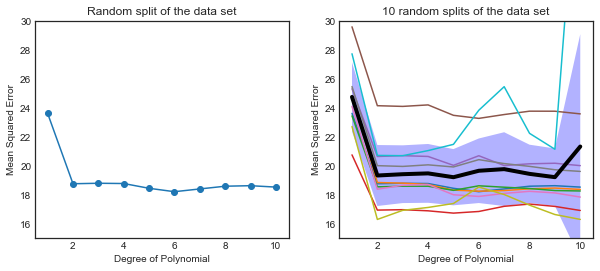

In [38]:
test_prop = 0.5
p_order = np.arange(1,11)
r_state = np.arange(0,10)

# r_state: 10 splits of the data 
# p_order: polynomials of order up to 10
X, Y = np.meshgrid(p_order, r_state, indexing='ij')
Z = np.zeros((p_order.size,r_state.size))

regr = skl_lm.LinearRegression()

# Generate 10 random splits of the dataset
for (i, j), v in np.ndenumerate(Z):
    poly = PolynomialFeatures(int(X[i,j]))
    X_poly = poly.fit_transform(df_auto.horsepower.values.reshape(-1,1))
    
    X_train, X_test, y_train, y_test = train_test_split(X_poly, df_auto.mpg.ravel(),
                                                        test_size=test_prop, random_state=Y[i,j])
                                                                        
    regr.fit(X_train, y_train)
    pred = regr.predict(X_test)
    Z[i, j] = mean_squared_error(y_test, pred)

# plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# Left plot (first split)
ax1.plot(X.T[0], Z.T[0], '-o')
ax1.set_title('Random split of the data set')

# Right plot (all splits)
ax2.plot(X, Z)
ax2.set_title('10 random splits of the data set')

for ax in fig.axes:
    ax.set_ylabel('Mean Squared Error')
    ax.set_ylim(15,30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5, 10.5)
    ax.set_xticks(range(2, 11, 2));
    
# mean and std
meanMSE = np.mean(Z, axis=1)
stdMSE = np.std(Z, axis=1)
ax2.plot(X.T[0], meanMSE, 'k', linewidth=4)
ax2.fill_between(X.T[0], meanMSE+stdMSE, meanMSE-stdMSE, facecolor='blue', alpha=0.3);
print(f'Mean \u00B1 std of MSE for p=2: {meanMSE[1]:.2f}\u00B1{stdMSE[1]:.2f}')

## 5.1.2 Leave-One-Out Cross-Validation

In [80]:
regr = skl_lm.LinearRegression()
loocv_scores = list()
loo = LeaveOneOut()

for p in p_order:
    poly = PolynomialFeatures(p)
    X_poly = poly.fit_transform(df_auto.horsepower.values.reshape(-1,1))
    score = cross_val_score(regr, X_poly, df_auto.mpg, cv=loo, scoring='neg_mean_squared_error')
    loocv_scores.append((-score.mean(), score.std()))
loocv_scores = np.array(loocv_scores)
print(f'Mean \u00B1 std of MSE for p=2: {loocv_scores[1,0]:.2f}\u00B1{loocv_scores[1,1]:.2f}')
# huge std!

Mean ± std of MSE for p=2: 19.25±35.00


## 5.1.3 k-Fold Cross-Validation

In [97]:
regr = skl_lm.LinearRegression()
kfoldcv_scores = list()

for p in p_order:
    poly = PolynomialFeatures(p)
    X_poly = poly.fit_transform(df_auto.horsepower.values.reshape(-1,1))
    # with shuffle=True we get much better mean and std
    # but then each train/test split is different across models
    kfold = KFold(n_splits=10, shuffle=True)
    score = cross_val_score(regr, X_poly, df_auto.mpg, cv=kfold, scoring='neg_mean_squared_error')
    kfoldcv_scores.append((-score.mean(), score.std()))
kfoldcv_scores = np.array(kfoldcv_scores)
print(f'Mean \u00B1 std of MSE for p=2: {kfoldcv_scores[1,0]:.2f}\u00B1{kfoldcv_scores[1,1]:.2f}')
# huge std!

Mean ± std of MSE for p=2: 19.31±6.55


### FIGURE 5.4

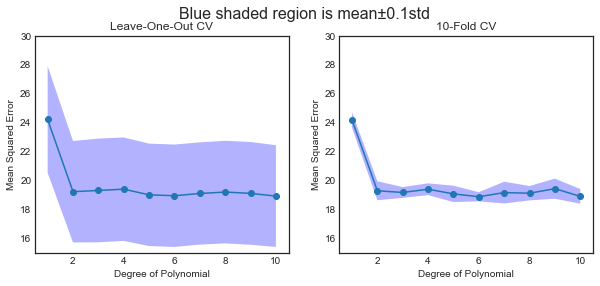

In [98]:
# plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('Blue shaded region is mean\u00B10.1std', fontsize=16)

# left plot is LOOCV
ax1.plot(p_order, loocv_scores[:,0], '-o')
ax1.set_title('Leave-One-Out CV')
ax1.fill_between(p_order, loocv_scores[:,0]+0.1*loocv_scores[:,1], loocv_scores[:,0]-0.1*loocv_scores[:,1],
                 facecolor='blue', alpha=0.3);

# right plot: K-fold CV
ax2.plot(p_order, kfoldcv_scores[:,0], '-o')
ax2.set_title('10-Fold CV')
ax2.fill_between(p_order, kfoldcv_scores[:,0]+0.1*kfoldcv_scores[:,1], kfoldcv_scores[:,0]-0.1*kfoldcv_scores[:,1],
                 facecolor='blue', alpha=0.3);

for ax in fig.axes:
    ax.set_ylabel('Mean Squared Error')
    ax.set_ylim(15,30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5, 10.5)
    ax.set_xticks(range(2, 11, 2));